# Remove Photobleaching

**Main function: photob_remove(** *video, fr, mask, n_ROIs_out=16, n_ROIs_in=16* **)**

Return ROIs masks, means from ROIs masks and time.

Divide cell mask into two major regions (inner and outter region), then divide these regions into smaller regions of interest (ROIs) with similar area following cell shape. The number of ROIs in each major region can be adjusted by *n_ROIs_out* and *n_ROIs_in* arguments. Also, get ROIs means over time from video.

**Parameters:**  
- **video: array**
    - (F x M x N) 16-bit gray image stack, where F are frames, M are lines and N are columns.
- **fr: int**
    - video frame rate (in frames per second).
- **mask: boolean array**
    - (M x N) boolean array. Must match video dimensions.
- **n_ROIs_out: int, optional**
    - number of ROIs in the outter region.
- **n_ROIs_in: int, optional**
    - number of ROIs in the inner region.
 
**Returns:**  
- **ROIs: boolean array**
    - (R x M x N) image stack, where R are ROI numbers (R = n_ROIs_in + n_ROIs_out), M are lines and N are columns.
- **ROIs_means: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **time: array**
    - (F,) array, where F are time points.


In [1]:
testing = (__name__ == "__main__")
if testing:
#     %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os
    rpbpath = os.path.abspath('')
    items = os.listdir(rpbpath)
    if rpbpath not in sys.path:
        sys.path.append(rpbpath)
    if 'MES.py' not in items:
        ! jupyter nbconvert --to 'python' MES.ipynb
    import MES as mes

## Mandatory Parameters:

In [2]:
if testing:
    from skimage import io
    fpath = 'Data\\Cell2\\videos_AP'
    fr = 55.78
    
    fname = 'avid_1.tif'
    fullpath = fpath + '\\' + fname
    video = io.imread(fullpath)
    
    mname = 'cellmask.tif'
    fullpath = fpath + '\\' + mname
    mask = io.imread(fullpath)
    

## Optional Parameters:

In [3]:
if testing:
    t_sig_onset=0.5
    t_sig_end=1
    transitory=True

## Apply MES:

In [4]:
if testing:
#     from ipynb.fs.full.MES import mes
    ROIs_masks, label_ROIs, ROIs_means, time  = mes.segment(mask, video, fr)

## Remove_Photobleaching functions:

In [5]:
def guess_t_sig_onset(vmean,time):
    '''Returns time and correspondig index where absolute maximum derivative is found, indicating signal rise/fall time'''
    import numpy as np
    d_vmean = abs(np.diff(vmean))
#     plt.plot(time[:-1],dROIs_means_corrected)
    dmax_idx = np.argmax(d_vmean) +1
#     if len(ROIs_means_corrected.shape)==2:
#         mode = np.argmax(np.bincount(dmax_idx))
#     else:
#         mode = dmax_idx

        
#     print(dmax_idx)
    
#     print(mode)
    t_sig_onset = time[dmax_idx]  
#     print('t_sig_onset=',t_sig_onset)
    return(t_sig_onset, dmax_idx)

In [6]:
def guess_t_sig_duration(vmean, time, t_sig_onset_idx):
    '''Returns indices of time vector later then t_sig_onset and when they are bigger than channel background noise'''
    import numpy as np
    noise_threshold = 2*np.std(vmean[:t_sig_onset_idx])
#     plt.plot(time,abs(vmean))
#     plt.plot(time,np.repeat(noise_threshold,len(time)),'b')
    t_sig_active = np.empty_like(vmean,dtype=bool)
#     for i in range(len(noise_threshold)):
    t_sig_active = np.where(abs(vmean)>noise_threshold,True,False)
    t_sig_active[:t_sig_onset_idx] = False
    i=t_sig_onset_idx
#     print(t_sig_active)
#     print('i0=',i)
    while(t_sig_active[i]==True):
        i+=1
#     print('i=',i)
    t_sig_end_idx = i
    return(time[t_sig_end_idx],t_sig_end_idx)
    

In [7]:
def guess_t_sig_prop(video,time,mask,transitory,t_sig_onset=None):
    '''Tries to find where signal starts and its duration by cell mask mean over time'''
    from scipy.signal import detrend
    import numpy as np
    video_masked = video*mask
    video_masked_mean = np.mean(video_masked,axis=(1,2))
    
    video_masked_mean_detrend = detrend(video_masked_mean,type='linear')
    if t_sig_onset is None:
        t_sig_onset, t_sig_onset_idx = guess_t_sig_onset(video_masked_mean_detrend,time)
    else:
        t_sig_onset_idx = np.argmin(abs(time-t_sig_onset))
    
    if transitory==True:
        t_sig_end,t_sig_end_idx = guess_t_sig_duration(video_masked_mean_detrend, time, t_sig_onset_idx)

        if t_sig_onset==t_sig_end:
            t_sig_end=None
        return(t_sig_onset, t_sig_onset_idx, t_sig_end)
    else:
        return(t_sig_onset, t_sig_onset_idx,None)
    
   

In [8]:
def create_inactive_idx_msk(video,time,mask,transitory=False,t_sig_onset=None,t_sig_end=None):
    '''Create vector masks indicating time periods of inactivity, i.e., where only noise is present'''
    import numpy as np
    #If there is no information about signal start, try to estimate from mean from cellmasked video
    if transitory==None:
        idx_msk = np.ones_like(time,dtype=bool)
#         print('!!!!')
        return(idx_msk,t_sig_onset,t_sig_end)
    if transitory==False:
        t_sig_end=None
    
        if (t_sig_onset==None):
            t_sig_onset,t_sig_onset_idx,t_sig_end = guess_t_sig_prop(video, time, mask,transitory)
            
    if transitory==True:
        if (t_sig_onset==None):
            t_sig_onset,t_sig_onset_idx,t_sig_end = guess_t_sig_prop(video, time, mask,transitory)
        elif t_sig_end is None:
            t_sig_onset,t_sig_onset_idx,t_sig_end = guess_t_sig_prop(video, time, mask,transitory,t_sig_onset)
            if t_sig_onset==t_sig_end:
                t_sig_end = None

    if t_sig_end is None:
        idx_msk = ((time>0) & (time<t_sig_onset-0.1))
    else:
        idx_msk = ((time>0) & (time<t_sig_onset-0.1)) | ((time>t_sig_end))
#     print(t_sig_onset)
#     print(t_sig_end)
    return(idx_msk,t_sig_onset,t_sig_end)

In [9]:
def monoexp(x, a, b, d):
    import numpy as np
    return a * np.exp(-b * x) + d

In [10]:
def monoexp_and_line(x, a, b, c, d):
    import numpy as np
    return a * np.exp(-b * x) - (c * x) + d

In [11]:
def monoexp_line_step(x, a, b, c, d, e,t_sig_onset): 
    import numpy as np
    return a * np.exp(-b * x) - (c * x) + d - e * (np.sign(x-t_sig_onset) + 1)

In [12]:
def monoexp_step(x, a, b, d, e,t_sig_onset): 
    import numpy as np
    return a * np.exp(-b * x) + d - e * (np.sign(x-t_sig_onset) + 1)

In [13]:
def photob_fit(ROIs_means,time,idx_msk,transitory,t_sig_onset):
    import numpy as np
    from scipy.optimize import curve_fit
#     microregions_avg_flat = []
#     lin_or_exp = []


#     count = np.arange(np.size(time)) +1

#     #Runs over the videos
#     video = []
#     for m,i,t,cnt in zip(ROIs_means,idx_msk,time,count):


    steps = np.empty(ROIs_means.shape[1])
    corrected = np.empty(ROIs_means.shape)
#     which_corr = np.empty(ROIs_means.shape[1])
    #Runs over the ROIs
    for j in range(ROIs_means.shape[1]):
        #Photobleaching is taken from inactivity intervals
        photobleaching = ROIs_means[idx_msk,j]

        #Tries different fit functions:
        #  1. Linear (all signals)
        #  2. Monoexponential
        #  3. Monoexponential + linear
        #  4. Monoexponential + step (just for step-like signal)
        #  5. Monoexponential + linear + step (just for step-like signal)

        y0 = np.mean(photobleaching[0:5])
        yf = np.mean(photobleaching[-5:])
        #FIT #1:    linear fit
        c, d = np.polyfit(time[idx_msk],photobleaching,1)
        p = np.poly1d([c,d])
        #Calculate residues
        res_linear = photobleaching - p(time[idx_msk])
        total_res_linear = np.sum(abs(res_linear**2))/len(photobleaching)
        
        #Assures y0 is bigger than yf for proper upper boundaries calculation
        if yf>=y0:
            if d>yf:
                y0 = d
            else:
                y0 = yf + 1

#             if cnt==3:
#                 res_linear = m[:,j] - p(t)
#                 total_res_linear = np.sum(abs(res_linear**2))/len(m[:,j])




        #If not last video (step-like signal)
        if ((transitory==True) | (transitory==None)):
#             #FIT #2:    monoexponential fit
#             #Tries to estimate upper_boundaries from information taken from linear fit
#             upper_bounds = [2*(y0-yf), 2*(np.log(d-(c*yf)-c)-np.log(y0-yf)), 2*yf]
# #             print('j=',j)
#             popt, pcov = curve_fit(monoexp, time[idx_msk], photobleaching,p0=[(y0-yf), (np.log(y0-yf)-np.log(y0-yf+c)), yf], bounds=(0, upper_bounds))
#             res_exp = photobleaching - monoexp(time[idx_msk], *popt)
#             total_res_exp = np.sum(abs(res_exp**2))/len(photobleaching)
#             #If any fit parameter gets close to its respective upper_boundary, expand upper_boundaries and retries fit
#             if np.all(np.greater(upper_bounds,popt+0.01*(popt)))==False:
#                 clip_flag = 1
# #                 print('WARNING: Data clipped by upper bound at region %d, monoexp fit' % j)
#                 while(clip_flag==1):
#                     close = np.isclose(upper_bounds,popt,atol=1e-02)
#                     previous_upper_bounds = np.copy(upper_bounds)
#                     if np.any(close)==False:  #if can't identify which parameter is clipped, duplicate all
#                         upper_bounds = np.multiply(2,upper_bounds)
#                     else:                     #if clipped parameter is identified, duplicate it
#                         closeidx = np.argwhere(close)[0][0]
#                         upper_bounds[closeidx] = np.multiply(2,upper_bounds[closeidx])
# #                     print('Expanding upper bounds!')
#                     popt, pcov = curve_fit(monoexp, time[idx_msk], photobleaching,p0=previous_upper_bounds, bounds=(0, upper_bounds))
#                     res_exp = photobleaching - monoexp(time[idx_msk], *popt)
#                     total_res_exp = np.sum(abs(res_exp**2))/len(photobleaching)
#                     if np.all(np.greater(upper_bounds,popt+0.01*(popt)))==True:
#                         clip_flag = 0
#                     #Breaks if either exponential coefficient or linear coefficients overflow
#                     if (popt[0]+popt[2]>1.2*y0)|(popt[1]<0.05):
#                         break

            #FIT #3:    monoexp and line fit
            upper_bounds = [2*(y0-yf), 2*(np.log(d-(c*yf)-c)-np.log(y0-yf)), 2*(abs(c)), 2*yf]
            popt2, pcov2 = curve_fit(monoexp_and_line, time[idx_msk], photobleaching, bounds=(0, upper_bounds))
            res_expline = photobleaching - monoexp_and_line(time[idx_msk], *popt2)
            total_res_expline = np.sum(abs(res_expline**2))/len(photobleaching)

            #If any fit parameter gets close to its respective upper_boundary, expand upper_boundaries and retries fit   
            if np.all(np.greater(upper_bounds,popt2+0.01*(popt2)))==False:
                clip_flag = 1
#                 print('WARNING: Data clipped by upper bound at region %d, monoexp and linear fit'% j)
                while(clip_flag==1):
                    close = np.isclose(upper_bounds,popt2,atol=1e-02)
                    if np.any(close)==False:  #if can't identify which parameter is clipped, duplicate all
                        upper_bounds = np.multiply(2,upper_bounds)
                    else:                     #if clipped parameter is identified, duplicate it
                        closeidx = np.argwhere(close)[0][0]
                        upper_bounds[closeidx] = np.multiply(2,upper_bounds[closeidx])
#                     print('Expanding upper bounds!')
                    popt2, pcov2 = curve_fit(monoexp_and_line, time[idx_msk], photobleaching, bounds=(0, upper_bounds))
                    res_expline = photobleaching - monoexp_and_line(time[idx_msk], *popt2)
                    total_res_expline = np.sum(abs(res_expline**2))/len(photobleaching)
#                         if cnt==3:
#                             res_expline = m[:,j] - monoexp_and_line(t, *popt2)
#                             total_res_expline = np.sum(abs(res_expline**2))/len(m[:,j])
                    if np.all(np.greater(upper_bounds,popt2+0.01*(popt2)))==True:
                        clip_flag = 0
                    #Breaks if either exponential coefficient or linear coefficients overflow
                    if (popt2[0]+popt2[3]>1.2*y0)|(popt2[1]<0.05):
                        break
        #If last video (step-like signal), perform fits including step
        #Inputs include whole data
        if transitory==False:

#             #FIT #4:     monoexp and step
#             upper_bounds = [2*(y0-yf), 2*(np.log(d-(c*yf)-c)-np.log(y0-yf)), 2*yf, (y0-yf)]
#             popt4, pcov4 = curve_fit(lambda x, a, b, d, e: monoexp_step(x,a,b,d,e,t_sig_onset), time, ROIs_means[:,j], bounds=(0, upper_bounds))
# #             print(type(popt4))
# #             print(*popt4+t_sig_onset)
#             res_expstep = ROIs_means[:,j] - monoexp_step(time, *np.insert(popt4,len(popt4),t_sig_onset))
#             total_res_expstep = np.sum(abs(res_expstep**2))/len(ROIs_means[:,j])
#             #If any fit parameter gets close to its respective upper_boundary, expand upper_boundaries and retries fit 
#             if np.all(np.greater(upper_bounds,popt4+0.01*(popt4)))==False:
#                 clip_flag = 1
# #                 print('WARNING: Data clipped by upper bound at region %d, exp_step'% j)
#                 while(clip_flag==1):
#                     close = np.isclose(upper_bounds,popt4,atol=1e-02)
#                     if np.any(close)==False:  #if can't identify which parameter is clipped, duplicate all
#                         upper_bounds = np.multiply(2,upper_bounds)
#                     else:
#                         closeidx = np.argwhere(close)[0][0]
#                         upper_bounds[closeidx] = np.multiply(2,upper_bounds[closeidx])
# #                     print('Expanding upper bounds!')
#                     popt4, pcov4 = curve_fit(lambda x, a, b, d, e: monoexp_step(x,a,b,d,e,t_sig_onset), time, ROIs_means[:,j], bounds=(0, upper_bounds))
#                     res_expstep = ROIs_means[:,j] - monoexp_step(time, *np.insert(popt4,len(popt4),t_sig_onset))
#                     total_res_expstep = np.sum(abs(res_expstep**2))/len(ROIs_means[:,j])
#                     if np.all(np.greater(upper_bounds,popt4+0.01*(popt4)))==True:
#                         clip_flag = 0
#                     #Breaks if either exponential coefficient or linear coefficients overflow
#                     if (popt4[0]+popt4[2]>1.2*y0)|(popt4[1]<0.05):
#                         break

            #FIT #5:     monoexp, line and step fit
            upper_bounds = [2*(y0-yf), 2*(np.log(d-(c*yf)-c)-np.log(y0-yf)), 2*(abs(c)), 2*yf, (y0-yf)]
#             print('y0,yf,c,d=',y0,yf,c,d,'in region ',j)
            popt3, pcov3 = curve_fit(lambda x, a, b, c, d, e: monoexp_line_step(x,a,b,c,d,e,t_sig_onset), time, ROIs_means[:,j], bounds=(0, upper_bounds))
            res_explinestep = ROIs_means[:,j] - monoexp_line_step(time, *np.insert(popt3,len(popt3),t_sig_onset))
            total_res_explinestep = np.sum(abs(res_explinestep**2))/len(ROIs_means[:,j])
            #If any fit parameter gets close to its respective upper_boundary, expand upper_boundaries and retries fit 
            if np.all(np.greater(upper_bounds,popt3+0.01*(popt3)))==False:
                clip_flag = 1
#                 print('WARNING: Data clipped by upper bound at region %d, exp_and_lin_step'% j)
                while(clip_flag==1):
                    close = np.isclose(upper_bounds,popt3,atol=1e-02)
                    if np.any(close)==False:  #if can't identify which parameter is clipped, duplicate all
                        upper_bounds = np.multiply(2,upper_bounds)
                    else:
                        closeidx = np.argwhere(close)[0][0]
                        upper_bounds[closeidx] = np.multiply(2,upper_bounds[closeidx])
#                     print('Expanding upper bounds!')
                    popt3, pcov3 = curve_fit(lambda x, a, b, c, d, e: monoexp_line_step(x,a,b,c,d,e,t_sig_onset), time, ROIs_means[:,j], bounds=(0, upper_bounds))
                    res_explinestep = ROIs_means[:,j] - monoexp_line_step(time, *np.insert(popt3,len(popt3),t_sig_onset))
                    total_res_explinestep = np.sum(abs(res_explinestep**2))/len(ROIs_means[:,j])
                    if np.all(np.greater(upper_bounds,popt3+0.01*(popt3)))==True:
                        clip_flag = 0
                    #Breaks if either exponential coefficient or linear coefficients overflow
                    if (popt3[0]+popt3[3]>1.2*y0)|(popt3[1]<0.05):
                        break

#             plt.figure(figsize=[15,10])
#     #             plt.subplot(m.shape[1],1,j+1)
#     #             plt.subplot(3,1,j+1)
#             plt.plot(t,m[:,j],'b-')
#             plt.plot(t[i],photobleaching,'.',ms=10,color='orange')
#             plt.plot(t, p(t),'r-.',label='linearfit: a=%5.1f, b=%5.1f; RES=%5.1f' % (c,d,total_res_linear))
#             if cnt<3:
#                 plt.plot(t, monoexp(t, *popt), 'g--', label='expfit: a=%5.1f, b=%5.2f, c=%5.1f; RES=%5.1f' % 
#                          (tuple(popt) + (total_res_exp,)))
#                 plt.plot(t, monoexp_and_line(t, *popt2), 'm--', 
#                          label='exp_and_line fit: a=%5.1f, b=%5.2f, c=%5.1f d=%5.1f; RES=%5.1f' % 
#                          (tuple(popt2) + (total_res_expline,)))
#     #             plt.plot(t, expline_mean, 'c--', label='expline_mean: RES=%5.1f' % total_res_expline_mean)
#             if cnt==3:
#                 plt.plot(t, monoexp_line_step(t, *popt3), 'k-.', 
#                              label='explinestepfit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f; RES=%5.1f' % 
#                              (tuple(popt3) + (total_res_explinestep,)))
#                 plt.plot(t, monoexp_step(t, *popt4), '-.',color='gray', 
#                              label='expstepfit: a=%5.3f, b=%5.3f, c=%5.3f, e=%5.3f; RES=%5.1f' % 
#                              (tuple(popt4) + (total_res_expstep,)))
#             plt.title('%s: %d' % (n,j))
#             #plt.legend(fontsize=12)

#         #Store correction number with lowest residuals
#         if ((transitory==True) | (transitory==None)):
#             argm = np.argmin(np.array([total_res_expline, total_res_exp, total_res_linear]))
#         else:
#             argm2 = np.argmin(np.array([total_res_explinestep, total_res_expstep, total_res_linear])) 


        #subtracts fit
        if ((transitory==True) | (transitory==None)):
#             if argm==2: #linear
#                 corrected[:,j] = ROIs_means[:,j] - p(time)
#             elif argm==1: #monoexponential 
#                 corrected[:,j] = ROIs_means[:,j] - monoexp(time, *popt)
#             elif argm==0: #exp and linear 
            corrected[:,j] = ROIs_means[:,j] - monoexp_and_line(time, *popt2)
#             which_corr[j] = argm
        else:
#             if argm2==2: #linear
#                 corrected[:,j] = ROIs_means[:,j] - p(time) 
#             elif argm2==1: #monoexponential (with step)
#                 #exclude step in order to leave just photobleaching
#                 steps[j] = np.copy(-2*popt4[-1])
#                 popt4[-1] = 0
#                 corrected[:,j] = ROIs_means[:,j] - monoexp_step(time, *np.insert(popt4,len(popt4),t_sig_onset))
#             elif argm2==0: #exp and linear (with step)
                #exclude step in order to leave just photobleaching
            steps[j] = np.copy(-2*popt3[-1])
            popt3[-1] = 0
            corrected[:,j] = ROIs_means[:,j] - monoexp_line_step(time, *np.insert(popt3,len(popt3),t_sig_onset))
#             popt3[-1] = 0
#             popt4[-1] = 0
#             which_corr[j] = argm2
        #First frame gets median to avoid some cases where exponential function is assigned mainly to the first frame 
        corrected[0,:] = np.mean(corrected[idx_msk,:],axis=0)

#             if cnt==3:
#                 testA[:,j] = monoexp_line_step(t, *popt3)
#                 plt.plot(t, testA[:,j], '--',color='m',label='explinestepfit minus step')
#                 testB[:,j] = monoexp_step(t, *popt4)
#                 plt.plot(t, testB[:,j], '--',color='lime',label='expstepfit minus step')
#             plt.legend()
#             imname0 = fpath + 'graphics/' + 'exp_corr_' + n + ' ' + str(j) + '.png'
#             plt.savefig(imname0,bbox_inches='tight')
#             plt.close()

#         if cnt<3:
        corrections=None
#     corrections = {
#         'lin': np.where(which_corr==2)[0],
#         'exp': np.where(which_corr==1)[0],
#         'exp&lin': np.where(which_corr==0)[0]
#     }

#         if cnt==3:
#             video.append({
#                 'lin': np.where(which_corr==0)[0]
#                 'exp': np.where(which_corr==1)[0]
#                 'exp&lin': np.where(which_corr==2)[0]
#             })

#         lin_or_exp.append(which_corr)
#         microregions_avg_flat.append(corrected)
#     corrections = {
#         'video1': video[0],
#         'video2': video[1],
#         'video3': video[2]
#     }
    return(corrected, corrections)

In [14]:
def photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset,t_sig_end):
    #Create vector masks indicating time periods of inactivity
    inactive_msk,t_sig_onset,t_sig_end = create_inactive_idx_msk(video,time,mask,transitory,t_sig_onset=t_sig_onset,t_sig_end=t_sig_end)

    ROIs_means_corrected, corrections = photob_fit(ROIs_means,time,inactive_msk,transitory,t_sig_onset)
    
    return(ROIs_means_corrected, corrections, inactive_msk, t_sig_onset, t_sig_end)

## Remove photobleaching from ROIs means:

In [16]:
if testing:
    ROIs_means_corrected, corrections, inactive_msk,t_sig_onset,t_sig_end  = photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset,t_sig_end)
    print('\nCorrections: ',corrections)
#     print('\nCorrections in video2&3: ',corrections['video2'])
#     print('\nCorrections in video4: ',corrections['video3'])


Corrections:  {'lin': array([], dtype=int64), 'exp': array([ 8, 14, 15], dtype=int64), 'exp&lin': array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64)}


In [17]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    ncolors = nregions
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
    newcolors = newcolors[:nregions]
    newcolors = brg(newcolors)
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)

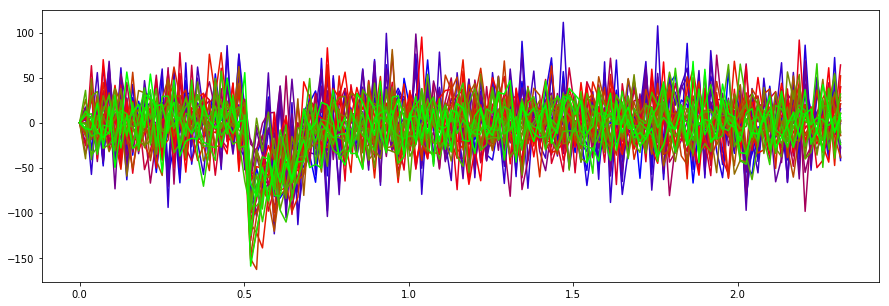

In [18]:
if testing:

    fig, ax1 = plt.subplots(figsize=[15,5])



    for i in range(nregions):

        ax1.plot(time,ROIs_means_corrected[:,i],color=newcolors[i+1])

In [20]:
if testing:
    print('Signal onset time:',t_sig_onset,'s')
    print('Signal end time:',t_sig_end,'s')

Signal onset time: 0.5 s
Signal end time: 1 s
